<a href="https://colab.research.google.com/github/tej06/flask-Stock-Prediction/blob/master/StockPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive/stock-prediction"

GOOG_2010.csv  GOOG_2018.csv		      linear_stock_regressor.pkl
GOOG_2016.csv  linear_stock_regressor.joblib  StockPrediction.ipynb


In [0]:
import numpy as np
import pandas as pd
import datetime

In [0]:
df = pd.read_csv("/content/drive/My Drive/stock-prediction/GOOG_2010.csv")
type(df["Date"][0])

str

In [0]:
#dynamically download data
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 8, 30)

df_appl = web.DataReader("AAPL", 'yahoo', start, end)
df_appl.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,207.190002,205.059998,205.860001,206.490005,26043600.0,206.490005
2019-08-27,208.550003,203.529999,207.860001,204.160004,25873300.0,204.160004
2019-08-28,205.720001,203.320007,204.100006,205.529999,15938800.0,205.529999
2019-08-29,209.320007,206.660004,208.500000,209.009995,20990500.0,209.009995
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005


In [0]:
#Moving average
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

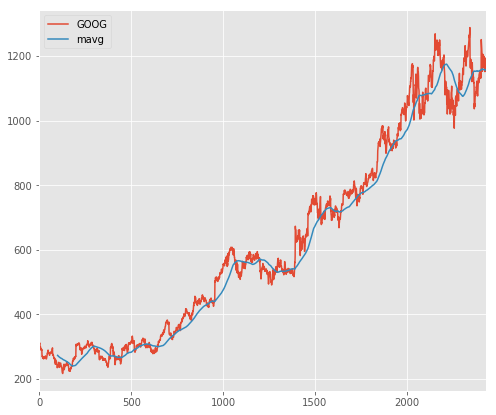

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='GOOG')
mavg.plot(label='mavg')
plt.legend()

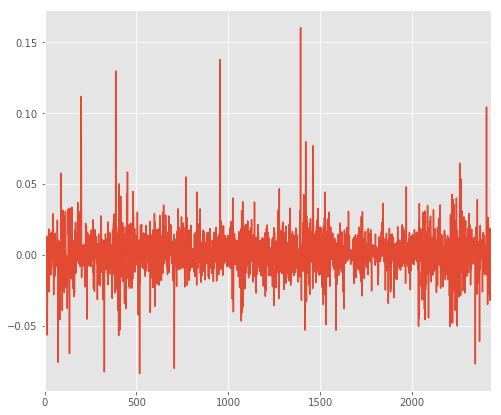

In [0]:
#Return Deviation
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [0]:
#Analysing Competitors Stocks
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']
dfcomp.tail()

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2019-08-26,206.490005,8.05,1168.890015,129.990005,135.449997
2019-08-27,204.160004,7.93,1167.839966,131.169998,135.740005
2019-08-28,205.529999,7.94,1171.020020,132.759995,135.559998
2019-08-29,209.009995,8.11,1192.849976,134.880005,138.119995
2019-08-30,208.740005,8.25,1188.099976,135.529999,137.860001


Text(0, 0.5, 'Returns GE')

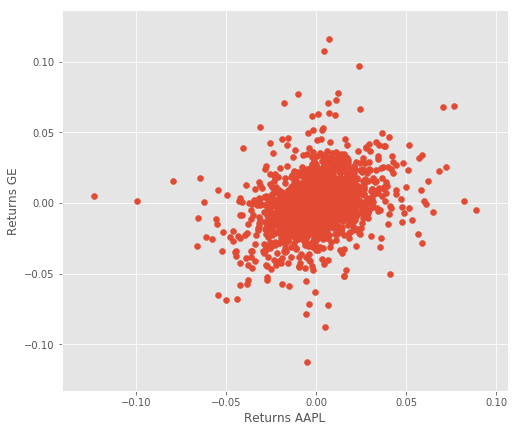

In [0]:
#Correlation Analysis
retscomp = dfcomp.pct_change()

corr = retscomp.corr()
corr.tail()

plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel("Returns AAPL")
plt.ylabel("Returns GE")

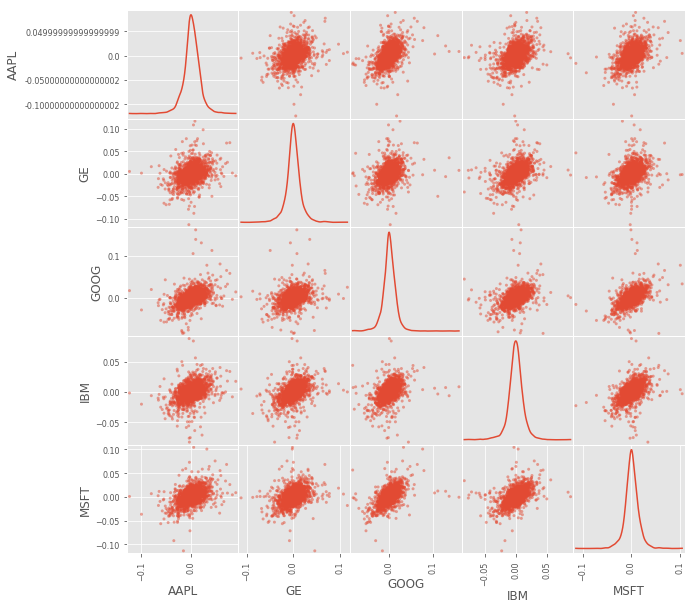

In [0]:
#Scatter Matrix
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

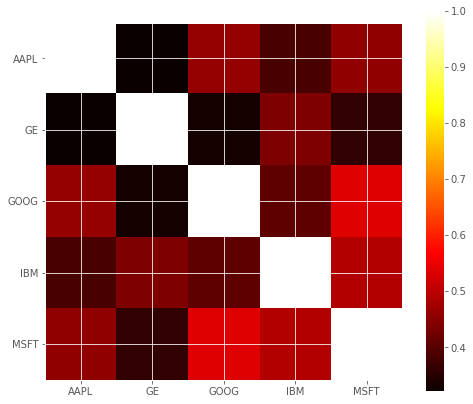

In [0]:
#Heat Maps: Notice that the lighter the color, the more correlated the two stocks are
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

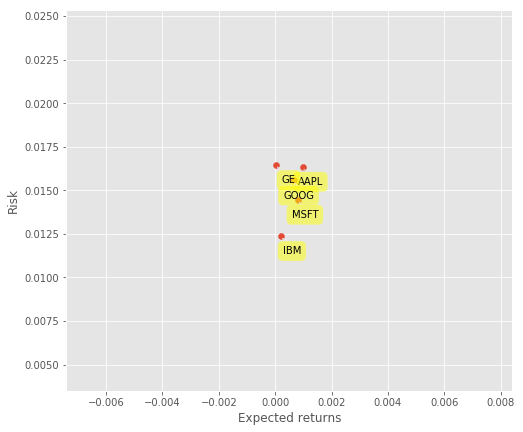

In [0]:
# Stocks return rate and risks
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [0]:
#Predicting stock prices

#Feature Enginnering
df.set_index("Date", inplace=True)
dfreg = df.loc[:,["Adj Close","Volume"]]
dfreg["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dfreg["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0
dfreg.tail()
#df.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-26,1168.890015,1226100,1.412452,1.004960
2019-08-27,1167.839966,1077200,1.793916,-1.074946
2019-08-28,1171.020020,802000,1.632764,0.801410
2019-08-29,1192.849976,1088400,1.252468,0.993124
2019-08-30,1188.099976,1129800,1.237019,-0.867753


## **Pre-processing & Cross Validation**
We will clean up and process the data using the following steps before putting them into the prediction models:


1.   Drop missing value
2.   Separating the label here, we want to predict the AdjClose
3.   Scale the X so that everyone can have the same distribution for linear regression
4.   Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
5.   Separate label and identify it as y
6.   Separation of training and testing of model by cross validation train test split


In [0]:
import math
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
print("Forecast out", forecast_out)

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

Forecast out 25


In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score  # Can't be used here as it is used only in case of classifications
from sklearn.model_selection import train_test_split

In [0]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X, y)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X, y)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [0]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [0]:
confidencereg = clfreg.score(X_test, y_test)
confidencepoly2 = clfpoly2.score(X_test,y_test)
confidencepoly3 = clfpoly3.score(X_test,y_test)
confidenceknn = clfknn.score(X_test, y_test)
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)

The linear regression confidence is  -0.4817090185377244
The quadratic regression 2 confidence is  -0.44075589816023486
The quadratic regression 3 confidence is  -0.2779516473090349
The knn regression confidence is  -0.7181174240875314


In [0]:
forecast_set = clfreg.predict(X_lately)
dfreg['Forecast'] = np.nan
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,
2019-08-26,1168.890015,1226100,1.412452,1.004960,NaN,NaN
2019-08-27,1167.839966,1077200,1.793916,-1.074946,NaN,NaN
2019-08-28,1171.020020,802000,1.632764,0.801410,NaN,NaN
2019-08-29,1192.849976,1088400,1.252468,0.993124,NaN,NaN
2019-08-30,1188.099976,1129800,1.237019,-0.867753,NaN,NaN


In [0]:
df_temp = dfreg

NameError: ignored

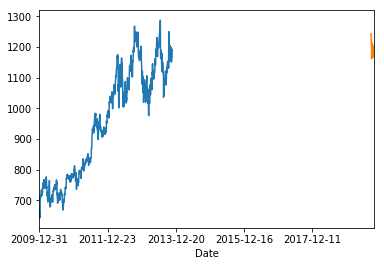

In [0]:
last_date = df_temp.iloc[-1].name
last_date = datetime.datetime.strptime(last_date, "%Y-%m-%d")
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df_temp.loc[(str(next_date)[:11])] = [np.nan for _ in range(len(df_temp.columns)-1)]+[i]
df_temp['Adj Close'].tail(1000).plot()
df_temp['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
df_temp.tail()

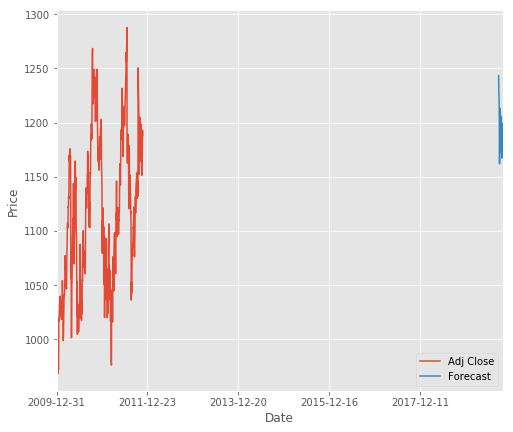

In [0]:
df_temp['Adj Close'].tail(500).plot()
df_temp['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [0]:
df_temp.tail(26)

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,
2019-08-30,1188.099976,1129800.0,1.237019,-0.867753,NaN,NaN
2019-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,1243.271617
2019-09-01 00:00:00,NaN,NaN,NaN,NaN,NaN,1229.401172
2019-09-02 00:00:00,NaN,NaN,NaN,NaN,NaN,1224.371440
2019-09-03 00:00:00,NaN,NaN,NaN,NaN,NaN,1217.391198
2019-09-04 00:00:00,NaN,NaN,NaN,NaN,NaN,1200.236411
2019-09-05 00:00:00,NaN,NaN,NaN,NaN,NaN,1161.894706
2019-09-06 00:00:00,NaN,NaN,NaN,NaN,NaN,1176.140685
2019-09-07 00:00:00,NaN,NaN,NaN,NaN,NaN,1182.448002


In [0]:
from sklearn.externals import joblib
  
# Save the model as a pickle in a file 
joblib.dump(clfreg, '/content/drive/My Drive/stock-prediction/linear_stock_regressor.joblib') 

['/content/drive/My Drive/stock-prediction/linear_stock_regressor.joblib']

In [0]:
# Load the model from the file 
clfreg_loaded = joblib.load('/content/drive/My Drive/stock-prediction/linear_stock_regressor.joblib')

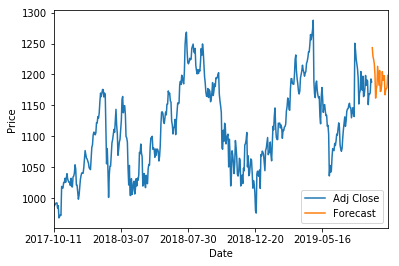

,Adj Close,Volume,HL_PCT,PCT_change,label,Forecast
Date,,,,,,
2019-09-20,NaN,NaN,NaN,NaN,NaN,1175.218592
2019-09-21,NaN,NaN,NaN,NaN,NaN,1177.257830
2019-09-22,NaN,NaN,NaN,NaN,NaN,1179.314399
2019-09-23,NaN,NaN,NaN,NaN,NaN,1198.761011
2019-09-24,NaN,NaN,NaN,NaN,NaN,1195.248943


In [0]:
import matplotlib.pyplot as plt
from matplotlib import style
df_temp['Adj Close'].tail(500).plot()
df_temp['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
df_temp.tail()

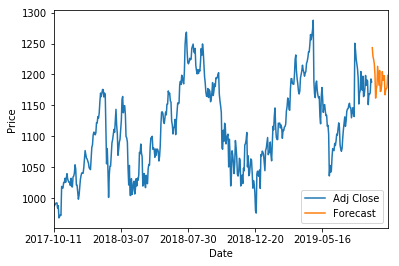



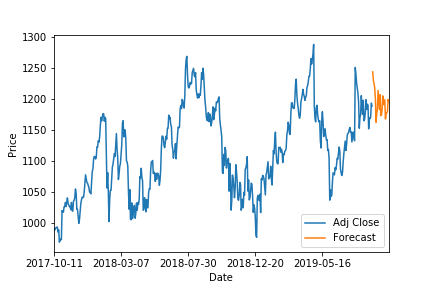

In [0]:
#To render plot in flask HTML
import io
import base64
img = io.BytesIO()
df_temp['Adj Close'].tail(500).plot()
df_temp['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.savefig(img, format='png')
plt.show()
img.seek(0)
graph_url = base64.b64encode(img.getvalue()).decode()
plt.close()
print('data:image/png;base64,{}'.format(graph_url))

In [0]:
len(forecast_set)

25